In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [5]:
path_to_POSCAR_MBT_unlabelled = 'added_4000_unlabelled_data/'
path_to_POSCAR_MBT_labelled = 'DFT_CONTCARs_MBT/'

In [6]:
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

In [7]:
poscar_info_list_labelled, atomic_species_list_labelled, unique_atomic_species_list_labelled = read_POSCAR(path_to_POSCAR_MBT_labelled)
poscar_info_list_unlabelled, atomic_species_list_unlabelled, unique_atomic_species_list_unlabelled = read_POSCAR(path_to_POSCAR_MBT_unlabelled)

unique_atomic_species_list = list(set(unique_atomic_species_list_labelled + unique_atomic_species_list_unlabelled))
poscar_info_list = poscar_info_list_labelled + poscar_info_list_unlabelled

In [8]:
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

In [9]:
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)
soap_desc_labelled = get_SOAP_descriptor(poscar_info_list_labelled, 9.0, 6, 5)

In [10]:
print(soap_desc.shape)
print(soap_desc_labelled.shape)

(4240, 79218)
(240, 79218)


In [11]:
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()

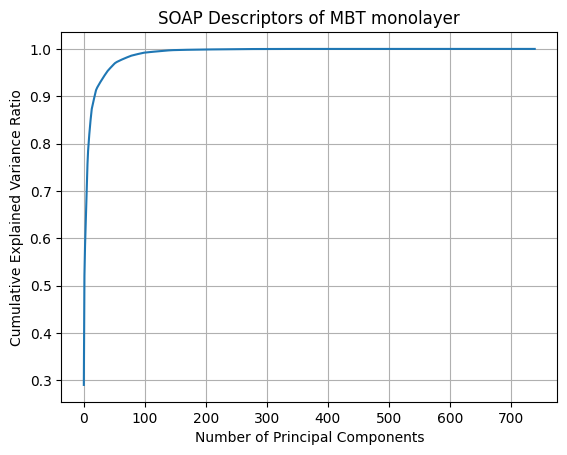

In [12]:
plot_PCA_variance(soap_desc,740)

In [13]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components=optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

In [14]:
optimized_pca = perform_pca(soap_desc,200)
optimized_pca_labelled = perform_pca(soap_desc_labelled,200)

In [15]:
print(optimized_pca.shape)
print(optimized_pca_labelled.shape)

(4240, 200)
(240, 200)


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
X_labelled = scaler.fit_transform(optimized_pca_labelled)

latent_size = 64
input_dim = X.shape[1]

In [17]:
encoder_input = keras.Input(shape=(input_dim,))
encoder_hid_layer_1 = keras.layers.Dense(128, activation = 'selu')(encoder_input)
encoder_hid_layer_2 = keras.layers.Dense(96, activation = 'selu')(encoder_hid_layer_1)
encoder_output = keras.layers.Dense(64, activation = 'selu')(encoder_hid_layer_2)

In [18]:
decoder_hid_layer_1 = keras.layers.Dense(96, activation = 'selu')(encoder_output)
decoder_hid_layer_2 = keras.layers.Dense(128, activation = 'selu')(decoder_hid_layer_1)
decoder_output = keras.layers.Dense(input_dim, activation = 'linear')(decoder_hid_layer_2)

In [19]:
autoencoder = keras.models.Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer='adam', loss = 'mae',)

In [20]:
hist_autoencoder = autoencoder.fit(X, X, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7540 - val_loss: 0.5986
Epoch 2/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5638 - val_loss: 0.5751
Epoch 3/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5126 - val_loss: 0.5591
Epoch 4/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4858 - val_loss: 0.5469
Epoch 5/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4565 - val_loss: 0.5362
Epoch 6/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4419 - val_loss: 0.5279
Epoch 7/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4229 - val_loss: 0.5187
Epoch 8/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4122 - val_loss: 0.5135
Epoch 9/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3981 - val_loss: 0.5084
Epoch 10/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3894 - val_loss: 0.5048
Epoch 11/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3842 - val_loss: 0.5009
Epoch 12/500
106/106 ━━━━━━━━━━━━━━━━━━━━

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3343 - val_loss: 0.4790
Epoch 69/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3298 - val_loss: 0.4793
Epoch 70/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3281 - val_loss: 0.4804
Epoch 71/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3273 - val_loss: 0.4792
Epoch 72/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3315 - val_loss: 0.4772
Epoch 73/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3242 - val_loss: 0.4785
Epoch 74/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3271 - val_loss: 0.4784
Epoch 75/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3268 - val_loss: 0.4775
Epoch 76/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3252 - val_loss: 0.4776
Epoch 77/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3233 - val_loss: 0.4777
Epoch 78/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3252 - val_loss: 0.4791
Epoch 79/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2939 - val_loss: 0.4795
Epoch 136/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2911 - val_loss: 0.4788
Epoch 137/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2973 - val_loss: 0.4801
Epoch 138/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892 - val_loss: 0.4782
Epoch 139/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2943 - val_loss: 0.4799
Epoch 140/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2940 - val_loss: 0.4776
Epoch 141/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2939 - val_loss: 0.4799
Epoch 142/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2956 - val_loss: 0.4782
Epoch 143/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2922 - val_loss: 0.4785
Epoch 144/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2885 - val_loss: 0.4793
Epoch 145/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2912 - val_loss: 0.4785
Epoch 146/500
106/106

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2728 - val_loss: 0.4736
Epoch 202/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2735 - val_loss: 0.4723
Epoch 203/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2733 - val_loss: 0.4731
Epoch 204/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2708 - val_loss: 0.4727
Epoch 205/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2728 - val_loss: 0.4744
Epoch 206/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2776 - val_loss: 0.4757
Epoch 207/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2717 - val_loss: 0.4725
Epoch 208/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2711 - val_loss: 0.4730
Epoch 209/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2673 - val_loss: 0.4752
Epoch 210/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2746 - val_loss: 0.4737
Epoch 211/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2728 - val_loss: 0.4730
Epoch 212/500
106/106 ━━━━━━━━━━━━━

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2588 - val_loss: 0.4739
Epoch 268/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2631 - val_loss: 0.4734
Epoch 269/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2636 - val_loss: 0.4737
Epoch 270/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2651 - val_loss: 0.4730
Epoch 271/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2620 - val_loss: 0.4736
Epoch 272/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2635 - val_loss: 0.4745
Epoch 273/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2613 - val_loss: 0.4730
Epoch 274/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2600 - val_loss: 0.4723
Epoch 275/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2663 - val_loss: 0.4736
Epoch 276/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2634 - val_loss: 0.4747
Epoch 277/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2601 - val_loss: 0.4715
Epoch 278/500
106/106 ━━━━━━━━━━━━━

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2505 - val_loss: 0.4728
Epoch 334/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2529 - val_loss: 0.4727
Epoch 335/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2547 - val_loss: 0.4729
Epoch 336/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2524 - val_loss: 0.4733
Epoch 337/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.4734
Epoch 338/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2568 - val_loss: 0.4730
Epoch 339/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2546 - val_loss: 0.4702
Epoch 340/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2510 - val_loss: 0.4706
Epoch 341/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2482 - val_loss: 0.4723
Epoch 342/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2492 - val_loss: 0.4731
Epoch 343/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2541 - val_loss: 0.4731
Epoch 344/500
106/106 ━━━━━━━━━━━━━

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2461 - val_loss: 0.4693
Epoch 400/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2475 - val_loss: 0.4692
Epoch 401/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2420 - val_loss: 0.4703
Epoch 402/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2435 - val_loss: 0.4685
Epoch 403/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2400 - val_loss: 0.4694
Epoch 404/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2440 - val_loss: 0.4705
Epoch 405/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2459 - val_loss: 0.4675
Epoch 406/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2448 - val_loss: 0.4717
Epoch 407/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2443 - val_loss: 0.4713
Epoch 408/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2436 - val_loss: 0.4689
Epoch 409/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2434 - val_loss: 0.4701
Epoch 410/500
106/106 ━━━━━━━━━━━━━

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2368 - val_loss: 0.4711
Epoch 466/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2416 - val_loss: 0.4690
Epoch 467/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2413 - val_loss: 0.4696
Epoch 468/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2373 - val_loss: 0.4709
Epoch 469/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2379 - val_loss: 0.4714
Epoch 470/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2376 - val_loss: 0.4713
Epoch 471/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2389 - val_loss: 0.4705
Epoch 472/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2411 - val_loss: 0.4725
Epoch 473/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2365 - val_loss: 0.4706
Epoch 474/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2356 - val_loss: 0.4730
Epoch 475/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2396 - val_loss: 0.4712
Epoch 476/500
106/106 ━━━━━━━━━━━━━

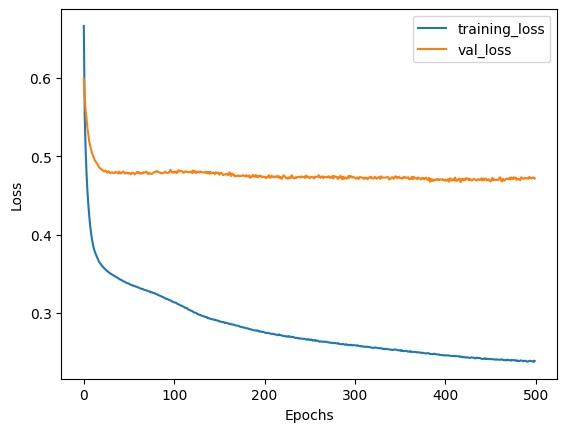

In [21]:
plt.plot(hist_autoencoder.history['loss'], label='training_loss')
plt.plot(hist_autoencoder.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
reconstructed_X = autoencoder.predict(X)
reconstructed_X_labelled = autoencoder.predict(X_labelled)

encoder = keras.models.Model(inputs = encoder_input, outputs = encoder_output)

compressed_X = encoder.predict(X)
compressed_X_labelled = encoder.predict(X_labelled)

print(compressed_X.shape)
print(compressed_X_labelled.shape)

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(4240, 64)
(240, 64)


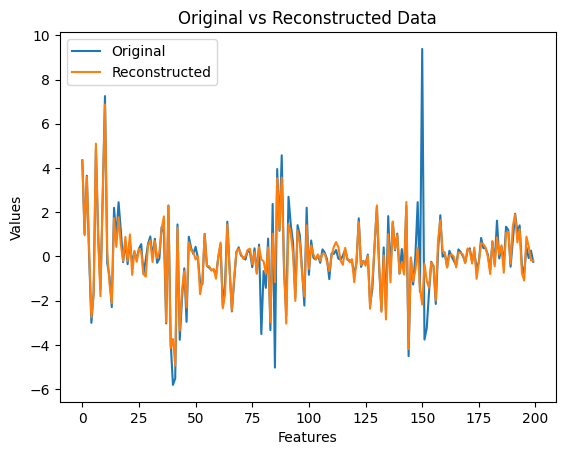

In [23]:
sample_idx = X[0]
plt.plot(X[0], label='Original')
plt.plot(reconstructed_X[0], label='Reconstructed')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Original vs Reconstructed Data')
plt.legend()
plt.show()

In [24]:
## FFNN

In [25]:
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')

In [26]:
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell','Eg']]

In [27]:
ffnn_MBT = keras.models.Sequential([
    keras.layers.Dense(32, activation = 'selu', input_dim = latent_size),
    keras.layers.Dense(16, activation = 'selu'),
    keras.layers.Dense(8, activation = 'selu'),
    keras.layers.Dense(3, activation = 'linear')
])

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(compressed_X_labelled, y, test_size = 0.2, random_state = 1)

In [29]:
ffnn_MBT.compile(optimizer = 'adam', loss = 'mae')
hist_ffnn_MBT = ffnn_MBT.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.5800 - val_loss: 1.2910
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3016 - val_loss: 1.2131
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1798 - val_loss: 1.1276
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0221 - val_loss: 1.0496
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9609 - val_loss: 0.9867
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8723 - val_loss: 0.9477
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7954 - val_loss: 0.9151
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7831 - val_loss: 0.8832
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7507 - val_loss: 0.8611
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6988 - val_loss: 0.8470
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6769 - val_loss: 0.8222
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6562 - val_lo

Epoch 70/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2535 - val_loss: 0.6136
Epoch 71/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2581 - val_loss: 0.6142
Epoch 72/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2708 - val_loss: 0.6125
Epoch 73/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2448 - val_loss: 0.6095
Epoch 74/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2628 - val_loss: 0.6064
Epoch 75/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2537 - val_loss: 0.6041
Epoch 76/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2505 - val_loss: 0.6071
Epoch 77/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2420 - val_loss: 0.6044
Epoch 78/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2252 - val_loss: 0.6049
Epoch 79/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2416 - val_loss: 0.6043
Epoch 80/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2321 - val_loss: 0.6070
Epoch 81/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2109

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1359 - val_loss: 0.5966
Epoch 139/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1324 - val_loss: 0.6123
Epoch 140/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1323 - val_loss: 0.5946
Epoch 141/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1314 - val_loss: 0.5952
Epoch 142/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1116 - val_loss: 0.6019
Epoch 143/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1335 - val_loss: 0.5992
Epoch 144/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1181 - val_loss: 0.6027
Epoch 145/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1142 - val_loss: 0.6118
Epoch 146/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1171 - val_loss: 0.6069
Epoch 147/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1176 - val_loss: 0.5985
Epoch 148/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1171 - val_loss: 0.6010
Epoch 149/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1206 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0519 - val_loss: 0.6483
Epoch 207/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0627 - val_loss: 0.6405
Epoch 208/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0687 - val_loss: 0.6284
Epoch 209/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0593 - val_loss: 0.6235
Epoch 210/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0661 - val_loss: 0.6346
Epoch 211/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0677 - val_loss: 0.6456
Epoch 212/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0659 - val_loss: 0.6314
Epoch 213/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0589 - val_loss: 0.6362
Epoch 214/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0545 - val_loss: 0.6384
Epoch 215/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0605 - val_loss: 0.6384
Epoch 216/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0592 - val_loss: 0.6326
Epoch 217/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0607 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0362 - val_loss: 0.6422
Epoch 275/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0337 - val_loss: 0.6421
Epoch 276/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0333 - val_loss: 0.6317
Epoch 277/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334 - val_loss: 0.6344
Epoch 278/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0256 - val_loss: 0.6364
Epoch 279/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0321 - val_loss: 0.6336
Epoch 280/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0306 - val_loss: 0.6352
Epoch 281/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0373 - val_loss: 0.6461
Epoch 282/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0361 - val_loss: 0.6461
Epoch 283/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - val_loss: 0.6465
Epoch 284/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0327 - val_loss: 0.6432
Epoch 285/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0340 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - val_loss: 0.6456
Epoch 343/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0277 - val_loss: 0.6385
Epoch 344/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - val_loss: 0.6384
Epoch 345/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 - val_loss: 0.6391
Epoch 346/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0273 - val_loss: 0.6308
Epoch 347/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - val_loss: 0.6385
Epoch 348/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0277 - val_loss: 0.6312
Epoch 349/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.6310
Epoch 350/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - val_loss: 0.6342
Epoch 351/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0258 - val_loss: 0.6259
Epoch 352/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0350 - val_loss: 0.6270
Epoch 353/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0261 - va

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - val_loss: 0.6320
Epoch 411/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212 - val_loss: 0.6340
Epoch 412/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241 - val_loss: 0.6361
Epoch 413/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - val_loss: 0.6365
Epoch 414/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - val_loss: 0.6373
Epoch 415/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235 - val_loss: 0.6315
Epoch 416/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225 - val_loss: 0.6331
Epoch 417/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258 - val_loss: 0.6358
Epoch 418/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248 - val_loss: 0.6377
Epoch 419/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0256 - val_loss: 0.6351
Epoch 420/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234 - val_loss: 0.6350
Epoch 421/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - val_loss

Epoch 479/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - val_loss: 0.6393
Epoch 480/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0276 - val_loss: 0.6401
Epoch 481/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - val_loss: 0.6354
Epoch 482/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 - val_loss: 0.6325
Epoch 483/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - val_loss: 0.6360
Epoch 484/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.6360
Epoch 485/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219 - val_loss: 0.6409
Epoch 486/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209 - val_loss: 0.6362
Epoch 487/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - val_loss: 0.6302
Epoch 488/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - val_loss: 0.6320
Epoch 489/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - val_loss: 0.6310
Epoch 490/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.02

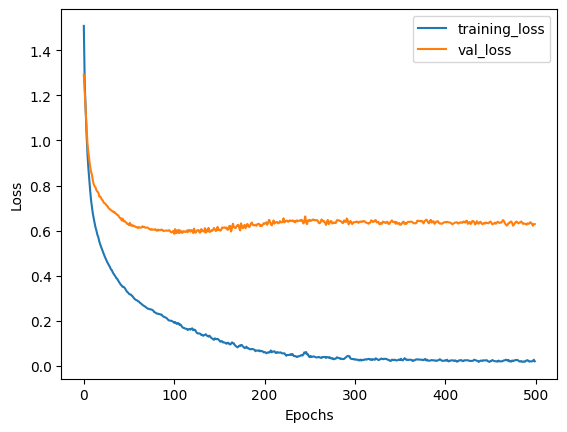

In [30]:
plt.plot(hist_ffnn_MBT.history['loss'], label='training_loss')
plt.plot(hist_ffnn_MBT.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
pred_train = ffnn_MBT.predict(X_train)
pred_test = ffnn_MBT.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


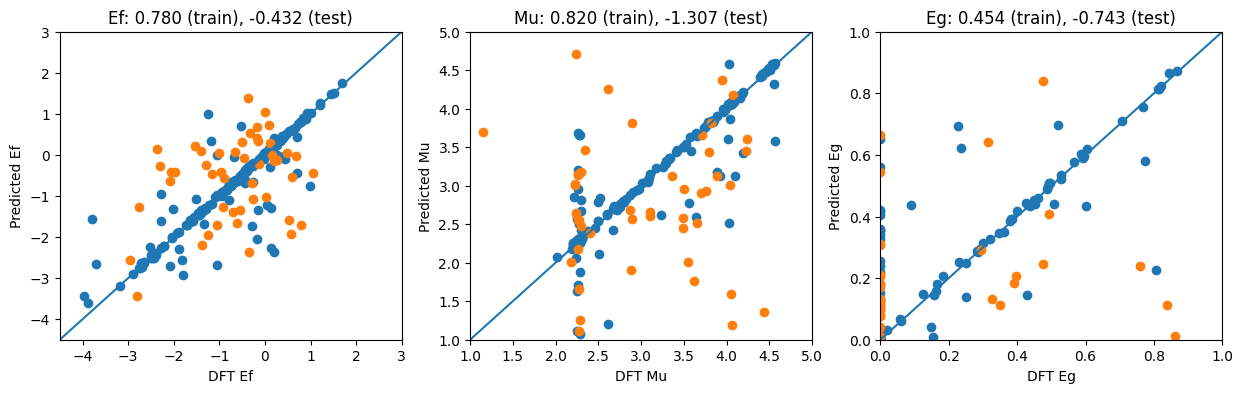

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train['Ef_per_cell'], pred_train[:,0])
ax1.scatter(y_test['Ef_per_cell'], pred_test[:,0])
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[:,1])
ax2.scatter(y_test['Mu_per_cell'], pred_test[:,1])
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train['Eg'], pred_train[:,2])
ax3.scatter(y_test['Eg'], pred_test[:,2])
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]),metrics.r2_score(y_test['Eg'], pred_test[:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

plt.show()

In [33]:
print(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.r2_score(y_train['Eg'], pred_train[:,2]))

0.7799313815495397
0.8200241884731224
0.4537028816747001


In [34]:
print(metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.mean_absolute_error(y_train['Eg'], pred_train[:,2]))

0.21673783703391084
0.14467782356838385
0.07211731959724178


In [35]:
print(metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.r2_score(y_test['Eg'], pred_test[:,2]))

-0.4320079327276458
-1.3065614309439098
-0.7432950656409378


In [36]:
print(metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.mean_absolute_error(y_test['Eg'], pred_test[:,2]))

1.004640329508118
0.9072945844729742
0.24468686811427276
